In [1]:
import certifi
import ssl
import os

# Update the SSL certificates
os.environ['SSL_CERT_FILE'] = certifi.where()
from tensorflow.keras.applications import Xception, VGG16, MobileNetV2,  EfficientNetB7, ResNet50, InceptionV3

# Creating a simple model for testing
try:
    vgg19_model = VGG16(weights='imagenet', include_top=False)
    print("VGG16 model loaded successfully")
except Exception as e:
    print("Error loading VGG16 model:", e)

try:
    xception_model = Xception(weights='imagenet', include_top=False)
    print("Xception model loaded successfully")
except Exception as e:
    print("Error loading Xception model:", e)

try:
    mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False)
    print("MobileNetV2 model loaded successfully")
except Exception as e:
    print("Error loading MobileNetV2 model:", e)

try:
    ResNet_model = ResNet50(weights='imagenet', include_top=False)
    print("ResNet50 model loaded successfully")
except Exception as e:
    print("Error loading ResNet50 model:", e)

try:
    inception_model = InceptionV3(weights='imagenet', include_top=False)
    print("InceptionV3 model loaded successfully")
except Exception as e:
    print("Error loading InceptionV3 model:", e)

try:
    efficient_model = EfficientNetB7(weights='imagenet', include_top=False)
    print("EfficientNetB7 model loaded successfully")
except Exception as e:
    print("Error loading EfficientNetB7 model:", e)


VGG16 model loaded successfully
Xception model loaded successfully


/var/folders/4k/8zlccwcn4c56fvv8y69dh2400000gn/T/ipykernel_21393/913066274.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False)


MobileNetV2 model loaded successfully
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
ResNet50 model loaded successfully
InceptionV3 model loaded successfully
EfficientNetB7 model loaded successfully


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, Multiply, Add, Reshape, Lambda, Input
from tensorflow.keras.models import Model

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    print(f'Input feature shape (channel attention): {input_feature.shape}')
    
    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    print(f'Avg pool shape: {avg_pool.shape}')
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    print(f'Avg pool after dense layers shape: {avg_pool.shape}')
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    print(f'Max pool shape: {max_pool.shape}')
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    print(f'Max pool after dense layers shape: {max_pool.shape}')
    
    # Ensure both tensors have the same shape
    assert avg_pool.shape == max_pool.shape, f"Shape mismatch: avg_pool {avg_pool.shape}, max_pool {max_pool.shape}"
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = tf.nn.sigmoid(cbam_feature)
    print(f'CBAM feature shape (channel attention): {cbam_feature.shape}')
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    print(f'Input feature shape (spatial attention): {input_feature.shape}')
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = tf.concat([avg_pool, max_pool], axis=3)
    print(f'Concat shape: {concat.shape}')
    cbam_feature = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    print(f'CBAM feature shape (spatial attention): {cbam_feature.shape}')
    
    return Multiply()([input_feature, cbam_feature])

def attention_block(input_feature):
    cbam_feature = channel_attention(input_feature)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


In [3]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    return filename.lower().endswith(valid_extensions)

def load_image(img_path, img_size=(96, 96)):
    try:
        with Image.open(img_path) as img:
            img = img.resize(img_size)
            return np.array(img)
    except Exception as e:
        print(f"Warning: Unable to read image {img_path}: {e}")
        return None

def load_images_and_labels(data_dir, img_size=(96, 96), max_workers=8):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Ensure class names are sorted
    img_paths = []
    img_labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                if is_image_file(img_file):
                    img_paths.append(img_path)
                    img_labels.append(label)

    # Use ThreadPoolExecutor for parallel image loading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        loaded_images = list(executor.map(load_image, img_paths, [img_size] * len(img_paths)))

    for img, label in zip(loaded_images, img_labels):
        if img is not None:
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

data_dir = 'Datasets/AffectNet'  

# Load and preprocess the data
images, labels = load_images_and_labels(data_dir, img_size=(96, 96), max_workers=8)

# Normalize the images
images = images / 255.0

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train)


In [ ]:
import cv2
import os
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import math
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from deepface import DeepFace

from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.offline as offline
from plotly.subplots import make_subplots
import random

from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras import layers
from keras.regularizers import *
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from keras import regularizers
from sklearn.metrics import confusion_matrix,classification_report
import plotly.graph_objs as go
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer



from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from deepface import DeepFace
import matplotlib.cm as cm
plt.style.use('fivethirtyeight')

In [ ]:
class Align_Face():
    def __init__(self):
        #definning opencv path for cascades
        opencv_home = cv2.__file__
        folders = opencv_home.split(os.path.sep)[0:-1]
        path = folders[0]
        for folder in folders[1:]:
            path = path + "/" + folder

        path_for_face = path+"/data/haarcascade_frontalface_default.xml"
        path_for_eyes = path+"/data/haarcascade_eye.xml"
        #loading Cascades
        self.face_detection_cascade = cv2.CascadeClassifier(path_for_face)
        self.eye_detection_cascade = cv2.CascadeClassifier(path_for_eyes)

    def face_detection(self,img):
        #getting bounding box of face
        faces = self.face_detection_cascade.detectMultiScale(img, 1.5, 5)
        if (len(faces) <= 0):
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            return img, img_gray
        else:
            X, Y, W, H = faces[0]
            #getting Face ROI
            img = img[int(Y):int(Y+H), int(X):int(X+W)]
            return img, cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)


    def trignometry_for_distance(self,a, b):
        return math.sqrt(((b[0] - a[0]) * (b[0] - a[0])) +\
                ((b[1] - a[1]) * (b[1] - a[1])))

    # Find eyes
    def Face_Alignment(self,img_path):
        img_raw = cv2.imread(img_path).copy()
        img, gray_img = self.face_detection(cv2.imread(img_path))
        #detecting Eyes
        eyes = self.eye_detection_cascade.detectMultiScale(gray_img)

        #checking if both eyes are present in the image
        if len(eyes) >= 2:
            eye = eyes[:, 2]
            container1 = []
            for i in range(0, len(eye)):
                container = (eye[i], i)
                container1.append(container)
            df = pd.DataFrame(container1, columns=[
                  "length", "idx"]).sort_values(by=['length'])
            eyes = eyes[df.idx.values[0:2]]
            

            eye_1 = eyes[0]
            eye_2 = eyes[1]
            #selecting left and right eye on the basis of their position
            if eye_1[0] > eye_2[0]:
                left_eye = eye_2
                right_eye = eye_1
            else:
                left_eye = eye_1
                right_eye = eye_2


            right_eye_center = (
            int(right_eye[0] + (right_eye[2]/2)),
            int(right_eye[1] + (right_eye[3]/2)))
            right_eye_x = right_eye_center[0]
            right_eye_y = right_eye_center[1]
            cv2.circle(img, right_eye_center, 2, (255, 0, 0), 3)

            left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)),int(left_eye[1] + (left_eye[3] / 2)))
            left_eye_x = left_eye_center[0]
            left_eye_y = left_eye_center[1]
            cv2.circle(img, left_eye_center, 2, (255, 0, 0), 3)


            if left_eye_y > right_eye_y:
#                 print("Rotate image to clock direction")
                point_3rd = (right_eye_x, left_eye_y)
                direction = -1 
            else:
#                 print("Rotate to inverse clock direction")
                point_3rd = (left_eye_x, right_eye_y)
                direction = 1 # rotate inverse direction of clock

            cv2.circle(img, point_3rd, 2, (255, 0, 0), 2)
            #calculating trignometric distance
            a = self.trignometry_for_distance(left_eye_center,
                        point_3rd)
            b = self.trignometry_for_distance(right_eye_center,
                        point_3rd)
            c = self.trignometry_for_distance(right_eye_center,
                        left_eye_center)
            cos_a = (b*b + c*c - a*a)/(2*b*c)
            angle = (np.arccos(cos_a) * 180) / math.pi
            
            #checking if we have to rotate image clock wise or anti clock wise
            if direction == -1:
                angle = 90 - angle
            else:
                angle = -(90-angle)

            new_img = Image.fromarray(img_raw)
            new_img = np.array(new_img.rotate(direction * angle))

        return new_img

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class Load_Datasets:
    def __init__(self, path="/young-affectnet-hq", size_images=(96, 96), gray=False, align_face=False, minimum_images=None, thresh_minimum=None):
        self.path = path
        self.size_images = size_images
        self.gray = gray
        self.align_face = align_face
        self.al_face = Align_Face() if align_face else None
        self.minimum_images = minimum_images
        self.thresh_minimum = thresh_minimum
        self.flags = []

    def load_images(self, directory):
        images, labels = [], []
        for emotion in tqdm(os.listdir(directory)):
            if emotion.startswith('.'):
                continue
            emotion_path = os.path.join(directory, emotion)
            image_files = [f for f in os.listdir(emotion_path) if not f.startswith('.')]
            if self.thresh_minimum and len(image_files) < self.thresh_minimum:
                self.flags.append(emotion)
                continue
            print(f"{emotion}: {len(image_files)} images")
            for i, image_file in enumerate(image_files):
                if self.minimum_images and i >= self.minimum_images:
                    break
                try:
                    img_path = os.path.join(emotion_path, image_file)
                    if self.align_face:
                        aligned_face = self.al_face.Face_Alignment(img_path)
                        face_img, gray_face_img = self.al_face.face_detection(aligned_face)
                        image = gray_face_img if self.gray else face_img[:, :, ::-1]
                    else:
                        image = cv2.imread(img_path)[:, :, ::-1]
                    image = cv2.resize(image, self.size_images)
                    images.append(image)
                    labels.append(emotion)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
        images = np.array(images)
        labels = np.array(labels)
        if self.gray:
            images = images.reshape(images.shape[0], -1).astype("float") / 255
        return images, labels

    def load_data(self):
        train_x, train_y, test_x, test_y = None, None, None, None
        for subdir in ["train", "test"]:
            subdir_path = os.path.join(self.path, subdir)
            if os.path.exists(subdir_path):
                print(f"Loading {subdir.capitalize()} Dataset")
                if subdir == "train":
                    train_x, train_y = self.load_images(subdir_path)
                else:
                    test_x, test_y = self.load_images(subdir_path)
        if train_x is None or test_x is None:
            print("Loading Dataset Directly | No Train-Test Folders")
            x, y = self.load_images(self.path)
            return x, y, None, None
        return train_x, train_y, test_x, test_y



In [ ]:
data = Load_Datasets(path="Datasets/AffectNet/",minimum_images=1000,size_images = (96, 96),align_face=False)
openfacex,openfacey,test_x,test_y = data.load_data()

Loading Dataset Directly | No Train-Test Folders


  0%|          | 0/8 [00:00<?, ?it/s]

happy: 5044 images


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

contempt: 2871 images


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

sad: 3091 images


 38%|███▊      | 3/8 [00:01<00:02,  1.79it/s]

fear: 3176 images


 50%|█████     | 4/8 [00:02<00:02,  1.99it/s]

surprise: 4039 images


 62%|██████▎   | 5/8 [00:02<00:01,  2.02it/s]

neutral: 5126 images


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

anger: 3218 images


 88%|████████▊ | 7/8 [00:04<00:00,  1.74it/s]

disgust: 2477 images


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


In [ ]:
df= pd.DataFrame()
df["labels"] = openfacey


In [ ]:
import pandas as pd
import plotly.express as px

def plot_data_distribution(data, label, emotion_labels):
    # Create a DataFrame with the labels and counts
    data_df = pd.DataFrame({
        'Emotion': emotion_labels,
        'Count': data['labels']
    })
    
    # Create a pie chart using Plotly Express
    fig = px.pie(
        data_df, 
        names='Emotion', 
        values='Count', 
        title=f"{label} Data Distribution",
        color_discrete_sequence=px.colors.qualitative.Pastel
    )

    # Update layout for better aesthetics
    fig.update_layout(
        title_font=dict(size=24, color='#333', family="Lato, sans-serif"),
        font=dict(color='#333', family="Lato, sans-serif"),
        hoverlabel=dict(bgcolor="#FFF", font_size=13, font_family="Lato, sans-serif"),
        legend=dict(
            title="Emotions",
            font=dict(
                family="Lato, sans-serif",
                size=12,
                color="black"
            ),
            bgcolor="#E2E2E2",
            bordercolor="#FFFFFF",
            borderwidth=2
        )
    )

    fig.show()

emotion_labels = ['happy', 'contempt', 'sad', 'fear', 'surprise', 'neutral', 'anger', 'disgust']
data_dist = pd.DataFrame(df["labels"].value_counts()).reset_index()
data_dist.columns = ['index', 'labels']
plot_data_distribution(data_dist, "AffectNet", emotion_labels)


In [ ]:
import numpy as np
import random
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_random_unique_sample(images, labels):
    unique_labels = np.unique(labels)
    selected_images = []
    selected_labels = []
    seen_labels = set()
    
    while len(seen_labels) < len(unique_labels):
        index = random.randint(0, len(images) - 1)
        label = labels[index]
        if label not in seen_labels:
            seen_labels.add(label)
            selected_images.append(images[index])
            selected_labels.append(label)
    
    return selected_images, selected_labels

def show_images(images, rows=1, titles=None, main_title=None):
    # Convert titles to a list if it's a NumPy array
    if isinstance(titles, np.ndarray):
        titles = titles.tolist()
    assert(titles is None or len(images) == len(titles))
    
    n_images = len(images)
    titles = titles if titles else [f'Image {i+1}' for i in range(n_images)]
    
    # Create a subplot with the number of rows and columns
    cols = int(np.ceil(n_images / rows))
    fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=titles)
    
    for i, image in enumerate(images):
        row = i // cols + 1
        col = i % cols + 1
        fig.add_trace(go.Image(z=image), row=row, col=col)

    fig.update_layout(height=300*rows, width=300*cols, title_text=main_title, title_x=0.5)
    fig.show()

imgss, labelss = get_random_unique_sample(openfacex,openfacey)
show_images(np.array(imgss), rows=2, titles=np.array(labelss), main_title="AffectNet Dataset")


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def preprocess(x, y, name):
    print("*" * 20, name, "*" * 20)
    
    x, y = np.array(x), np.array(y)
    unique_labels = np.unique(y)
    
    # Creating a dictionary to map labels to numeric encoding
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    etol = {index: label for index, label in enumerate(unique_labels)}  # Inverse mapping for later use
    
    # Encoding each label
    encoded_labels = [label_to_index[label] for label in y]
    
    # One hot encoding of labels
    y_encoded = to_categorical(encoded_labels)
    
    # Splitting training and testing dataset
    train_x, test_x, train_y, test_y = train_test_split(x, y_encoded, test_size=0.2, shuffle=True)
    
    print(f"Training set size: {len(train_x)} samples")
    print(f"Testing set size: {len(test_x)} samples")
    print("Shapes - Train X:", train_x.shape, "Train Y:", train_y.shape)
    print("Shapes - Test X:", test_x.shape, "Test Y:", test_y.shape)

    return train_x, test_x, train_y, test_y, etol

# Example usage with sample data
# Assuming `openfacex` and `openfacey` are your dataset images and labels
open_train_x, open_test_x, open_train_y, open_test_y, etol = preprocess(openfacex, openfacey, "OpenFace")


******************** OpenFace ********************
Training set size: 6400 samples
Testing set size: 1600 samples
Shapes - Train X: (6400, 96, 96, 3) Train Y: (6400, 8)
Shapes - Test X: (1600, 96, 96, 3) Test Y: (1600, 8)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19, Xception, MobileNetV2, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

class Model_Building:
    def __init__(self, model_name=None, train_x=None, train_y=None, test_x=None, test_y=None, model_check_point="Model_Checkpoints"):
        print("-" * 20, "Model Name:", model_name.upper(), "-" * 20)
        self.model_name = model_name
        self.check_point = model_check_point
        self.weights_path = 'Model_Checkpoints/pretrained_models/'
        
        if self.model_name == "vgg19":
            self.preprocess_input = tf.keras.applications.vgg19.preprocess_input
            self.model = VGG19
            
        elif self.model_name == "xception":
            self.preprocess_input = tf.keras.applications.xception.preprocess_input
            self.model = Xception
            
        elif self.model_name == "mobilenetv2":
            self.preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
            self.model = MobileNetV2
            
        elif self.model_name == "efficient":
            self.preprocess_input = tf.keras.applications.efficientnet.preprocess_input
            self.model = EfficientNetB7
            
        else:
            self.preprocess_input = tf.keras.applications.inception_v3.preprocess_input
            self.model = InceptionV3
            
        
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.main_model = None

    def base_model(self, data, pr_model):
        w, h = data.shape[1:3]
        cnn_model = pr_model(include_top=False, input_shape=(w, h, 3), weights=None)
        cnn_model.load_weights(os.path.join(self.weights_path, self.weights_file))
        
        inputs = Input((w, h, 3))
        x = Lambda(self.preprocess_input, name='preprocessing')(inputs)
        x = cnn_model(x)
        x = GlobalAveragePooling2D()(x)
        
        model = Model(inputs, x)
        features = model.predict(data, batch_size=5, verbose=1)
        return features

    def bottom_model(self, features):
        model = Sequential()
        model.add(Dense(300, activation="relu", input_shape=(features.shape[1],)))
        model.add(Dense(200, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(len(np.unique(self.train_y, axis=0)), activation="softmax"))
        model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
        return model

    def forward(self, batch_size=4, epochs=10, train_percent=0.90, verbose=1):
        f = self.base_model(self.train_x, self.model)
        percent = int(len(f) * train_percent)

        path1 = os.path.join(self.check_point, self.model_name)
        if not os.path.exists(path1):
            os.makedirs(path1)
        
        cp_callback = ModelCheckpoint(
            filepath="cp-{epoch:04d}.h5", 
            verbose=verbose, 
            save_freq=5 * batch_size
        )

        self.main_model = self.bottom_model(f)
        self.main_model.save_weights(self.check_point.format(epoch=0))
        
        hist = self.main_model.fit(
            f[:percent], self.train_y[:percent], 
            validation_data=(f[percent:], self.train_y[percent:]),
            batch_size=batch_size, epochs=epochs, callbacks=[cp_callback]
        )
        
        return hist, self.main_model

    def predict(self, sample_test=None):
        if sample_test is None:
            test_f = self.base_model(self.test_x, self.model)
            p = self.main_model.predict(test_f)
        else:
            test_f = self.base_model(sample_test, self.model)
            p = self.main_model.predict(test_f)

        p = np.argmax(p, axis=1)
        return p

    def evaluate(self):
        test_f = self.base_model(self.test_x, self.model)
        loss, acc = self.main_model.evaluate(test_f, self.test_y)

        print("=" * 50, self.model_name, "=" * 50)
        print("On Test Data")
        print("Loss:", round(loss, 4))
        print("Accuracy:", round(acc, 4))

        return loss, acc


In [ ]:

def plot_Accuracy_Loss(history, name):
    # Create subplots with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))

    # Plot training and validation loss
    fig.add_trace(go.Scatter(
        y=history.history['loss'], mode='lines', name='Training Loss',
        line=dict(color='blue')),
        row=1, col=1
    )
    
    if 'val_loss' in history.history:
        fig.add_trace(go.Scatter(
            y=history.history['val_loss'], mode='lines', name='Validation Loss',
            line=dict(color='red')),
            row=1, col=1
        )

    # Plot training and validation accuracy
    fig.add_trace(go.Scatter(
        y=history.history['accuracy'], mode='lines', name='Training Accuracy',
        line=dict(color='blue')),
        row=1, col=2
    )

    if 'val_accuracy' in history.history:
        fig.add_trace(go.Scatter(
            y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy',
            line=dict(color='red')),
            row=1, col=2
        )

    # Update layout for the entire figure
    fig.update_layout(
        title=f"{name} Model Training History",
        xaxis_title='Epochs',
        yaxis_title='Value',
        template='plotly_white',
        showlegend=False  # Hide the legend in the main layout
    )

    # Update layout for individual subplots
    fig.update_xaxes(title_text='Epochs', row=1, col=1)
    fig.update_yaxes(title_text='Loss', row=1, col=1)
    fig.update_xaxes(title_text='Epochs', row=1, col=2)
    fig.update_yaxes(title_text='Accuracy', row=1, col=2)

    fig.show()



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import plotly.graph_objects as go

def plot_ROC(y_pred, y_test, etol=None):
    if etol is None:
        etol = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}
    
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_pred = lb.transform(y_pred)

    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        auc_score = roc_auc_score(y_test[:, i], y_pred[:, i])

        name = f"{etol[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title='Multiclass ROC Curve',
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        width=700, height=500,
        template='plotly_white'
    )

    fig.show()


In [ ]:
class Model_Building:
    def __init__(self,model_name=None,train_x=None,train_y=None,test_x=None,test_y=None,model_check_point = "Model_Checkpoints"):
        # Constructor for the Model_Building class
        # Initializes the class attributes
        print("-"*12,"Model Name: " ,model_name.upper(),"-"*20)
        self.model_name = model_name
        self.check_point = model_check_point
        # Sets the base model name
        if self.model_name == "vgg16":
            self.preprocess_input = keras.applications.vgg16.preprocess_input
            self.model = VGG16
        elif self.model_name == "xception":
            self.preprocess_input = keras.applications.xception.preprocess_input
            self.model = Xception
        elif self.model_name == "ResNet50":
            self.preprocess_input = keras.applications.resnet50.preprocess_input
            self.model = ResNet50
        elif self.model_name=="mobilenetv2":
            self.preprocess_input = keras.applications.mobilenet_v2.preprocess_input
            self.model = MobileNetV2
        elif self.model_name == "efficient":
            self.preprocess_input = tf.keras.applications.efficientnet.preprocess_input
            self.model = EfficientNetB7
        else:
            self.preprocess_input = keras.applications.inception_v3.preprocess_input
            self.model = InceptionV3
        # Sets the preprocessing function and the base model based on the model name provided
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        # Sets the training and testing data
        self.main_model = None
        # Initializes the main model to None
    
    def base_model(self,data,pr_model  ):
        # Builds the base model by extracting the features from the pre-trained model
        w,h = data.shape[1:3]
        # Extracts the width and height from the shape of the data
        cnn_model = pr_model(include_top=False, input_shape=(w, h, 3), weights='imagenet')
        # Initializes the pre-trained model without the fully connected layers
        
        inputs = Input((w, h, 3))
        x = inputs
        x = Lambda(self.preprocess_input, name='preprocessing')(x)
        # Applies the preprocessing function to the input data
        x = cnn_model(x)
        # Extracts the features from the pre-trained model
        x = GlobalAveragePooling2D()(x)
        # Performs global average pooling to reduce the number of parameters
        cnn_model = Model(inputs, x)
        # Sets the base model as the input and the extracted features
        features = cnn_model.predict(data, batch_size=5, verbose=1)
        # Extracts the features from the training or testing data
        return features
    
    # Define a function for the bottom model of the neural network
    def bottom_model(self,features):
        # Define the neural network architecture
        model = Sequential()
        model.add(layers.Dense(300, activation="relu", input_shape=(features.shape[1],)))
        model.add(layers.Dense(200, activation="relu"))
        model.add(BatchNormalization())
#         model.add(layers.Dense(1500, activation="relu"))
        model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.2))
        model.add(layers.Dense(len(np.unique(self.train_y, axis=0)), activation="softmax"))

        # Compile the model with appropriate settings
        model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

        # Return the trained model and its history
        return model

    # Define a function for running the entire neural network model
    def forward(self, batch_size=4, epochs=10, train_percent=0.90, verbose=1):
        # Extract features using the base model
        f = self.base_model(self.train_x,self.model)
        percent = int(len(f) * train_percent)

        path1 = os.path.join(self.check_point,self.model_name)
        # Train the bottom model using the extracted features
        if not os.path.exists(path1):
            os.mkdir(path1)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(path1,"cp-{epoch:04d}.checkpoint.weights.h5"), 
        verbose=verbose, 
        save_weights_only=True,
        save_freq=5*batch_size)
        self.main_model = self.bottom_model(f)
        self.main_model.save_weights(os.path.join(path1,"cp-{epoch:04d}.checkpoint.weights.h5").format(epoch=0))
        hist = self.main_model.fit(f[:percent], self.train_y[:percent], validation_data=(f[percent:], self.train_y[percent:]),
                batch_size=batch_size, epochs=epochs, callbacks=[cp_callback])
        
        # Return the history of the trained model and the trained model itself
        return hist, self.main_model

    # Define a function for making predictions with the trained neural network model
    def predict(self, sample_test=None):
        if sample_test is None:
            # Extract features using the base model for the test data
            test_f = self.base_model(self.test_x,self.model)

            # Make predictions using the trained model
            p = self.main_model.predict(test_f)
            p = np.argmax(p, axis=1)
        else:
            # Extract features using the base model for the given input data
            test_f = self.base_model(sample_test,self.model)

            # Make predictions using the trained model
            p = self.main_model.predict(test_f)
            p = np.argmax(p, axis=1)

        # Return the predicted classes
        return p

    # Define a function for evaluating the performance of the trained neural network model
    def evaluate(self):
        # Extract features using the base model for the test data
        test_f = self.base_model(self.test_x,self.model)

        # Evaluate the performance of the trained model on the test data
        loss, acc = self.main_model.evaluate(test_f, self.test_y)

        # Print the results
        print("="*50, self.model_name, "="*50)
        print("On Test Data")
        print("Loss: ", round(loss, 4))
        print("Accuracy: ", round(acc, 4))

        # Return the loss and accuracy of the trained model on the test data
        return loss, acc


In [ ]:
incept = Model_Building("inception", train_x=open_train_x, train_y=open_train_y, test_x=open_test_x, test_y=open_test_y)
incept_hist, incept_model = incept.forward(verbose=1, batch_size=16, epochs=50)
incept_loss, incept_acc = incept.evaluate()


------------ Model Name:  INCEPTION --------------------
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 76s 58ms/step
Epoch 1/50
 66/360 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1129 - loss: 3.8159
Epoch 1: saving model to Model_Checkpoints/inception/cp-0001.checkpoint.weights.h5
156/360 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1303 - loss: 3.7464
Epoch 1: saving model to Model_Checkpoints/inception/cp-0001.checkpoint.weights.h5
236/360 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1377 - loss: 3.7012
Epoch 1: saving model to Model_Checkpoints/inception/cp-0001.checkpoint.weights.h5
316/360 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1433 - loss: 3.6665
Epoch 1: saving model to Model_Checkpoints/inception/cp-0001.checkpoint.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1460 - loss: 3.6484 - val_accuracy: 0.2125 - val_loss: 3.2132
Epoch 2/50
 38/360 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2190 - loss: 3.1954
Epoch 2: saving model to Model_Checkpoints/inception

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

In [ ]:

xcept = Model_Building("xception", train_x=open_train_x, train_y=open_train_y, test_x=open_test_x, test_y=open_test_y)
xcept_hist, xcept_model = xcept.forward(verbose=1, batch_size=16, epochs=50)
xcept_loss, xcept_acc = xcept.evaluate()

In [ ]:

mobilenet = Model_Building("mobilenetv2", train_x=open_train_x, train_y=open_train_y, test_x=open_test_x, test_y=open_test_y)
mobilenet_hist, mobilenet_model = mobilenet.forward(verbose=1, batch_size=16, epochs=50)
mobilenet_loss, mobilenet_acc = mobilenet.evaluate()


------------ Model Name:  MOBILENETV2 --------------------
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step
Epoch 1/50
 75/360 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1456 - loss: 3.8087
Epoch 1: saving model to Model_Checkpoints/mobilenetv2/cp-0001.checkpoint.weights.h5
156/360 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1740 - loss: 3.6804
Epoch 1: saving model to Model_Checkpoints/mobilenetv2/cp-0001.checkpoint.weights.h5
238/360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1940 - loss: 3.5906
Epoch 1: saving model to Model_Checkpoints/mobilenetv2/cp-0001.checkpoint.weights.h5
311/360 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2060 - loss: 3.5323
Epoch 1: saving model to Model_Checkpoints/mobilenetv2/cp-0001.checkpoint.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2130 - loss: 3.4982 - val_accuracy: 0.3172 - val_loss: 2.8825
Epoch 2/50
 34/360 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3818 - loss: 

In [ ]:

efficient = Model_Building("efficient", train_x=open_train_x, train_y=open_train_y, test_x=open_test_x, test_y=open_test_y)
efficient_hist, efficient_model = efficient.forward(verbose=1, batch_size=16, epochs=50)
efficient_loss, efficient_acc = efficient.evaluate()


In [ ]:

vgg = Model_Building("vgg19", train_x=open_train_x, train_y=open_train_y, test_x=open_test_x, test_y=open_test_y)
vgg_hist, vgg_model = vgg.forward(verbose=1, batch_size=16, epochs=50)
vgg_loss, vgg_acc = vgg.evaluate()


In [ ]:
plot_Accuracy_Loss(incept_hist,"Inception")
plot_Accuracy_Loss(xcept_hist,"Xception")
plot_Accuracy_Loss(mobilenet_hist,"MobileNet")
plot_Accuracy_Loss(vgg_hist,"VGG")
plot_Accuracy_Loss(efficient_hist,"Efficient")


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG19, Xception, MobileNetV2, InceptionV3, EfficientNetB7

def get_random_unique_sample(data, labels, n=10):
    # Dummy implementation for example purposes
    return data[:n], labels[:n]

def show_images(images, titles, rows=1, main_title=""):
    # Dummy implementation for example purposes
    fig, axes = plt.subplots(rows, len(images)//rows, figsize=(15, 5))
    for ax, img, title in zip(axes.flatten(), images, titles):
        ax.imshow(img)
        ax.set_title(title)
    plt.suptitle(main_title)
    plt.show()

def predict(model_obj, d={0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}, test_x=None, size=(224,224), model_path=None, save_img=None):
    '''If you are predicting from a saved model, the saved model should have its name directory where model checkpoints are present.'''
    print("Predicted Emotions")
    
    # If there is no test_x (test images array) given, it will take it from the defined model attribute
    if model_path is None:
        # Predict the test images from the defined model
        results = model_obj.predict()
        l = []
        # Inverse the encoded predicted labels using the dictionary defined above
        for i in results:
            l.append(d[i])
        # Show a sample of each class of predicted output
        imgs, la = get_random_unique_sample(model_obj.test_x, l)
        show_images(imgs, titles=la, rows=2, main_title="Predicted Emotions by " + model_obj.model_name)
        
        original_labels = []
        # Inverse the one hot encoded labels of original labels
        or_label = np.argmax(model_obj.test_y, axis=1)
        # Convert numeric original labels into actual names
        for i in or_label:
            original_labels.append(d[i])
        # Return test_x, predicted labels, and original labels
        return model_obj.test_x, l, original_labels
    else:
        # If only one image path is given in the parameter
        print("Predicting from Images Paths")
        if type(test_x) == str:
            img = cv2.imread(test_x)
            if img is None:
                raise ValueError(f"Image at path {test_x} could not be loaded.")
            imgs = cv2.resize(img, size)
            imgs = np.expand_dims(imgs, axis=0)
            print(f"Single image shape after resize and expand_dims: {imgs.shape}")
        else:
            # Array of images is given in the parameter
            imgs = []
            for img_path in test_x:
                img = cv2.imread(img_path)
                if img is None:
                    raise ValueError(f"Image at path {img_path} could not be loaded.")
                resized_img = cv2.resize(img, size)
                imgs.append(resized_img)
                print(f"Loaded and resized image: {img_path}, shape: {resized_img.shape}")
            imgs = np.array(imgs)
            print(f"Total images loaded: {len(imgs)}")
            if imgs.size == 0:
                raise ValueError("No images were loaded; please check the provided paths.")

        model_obj = Model_Building(model_name=model_obj)
        path1 = os.path.join(model_path, model_obj.model_name, "cp-{epoch:04d}.ckpt")
        latest = tf.train.latest_checkpoint(os.path.dirname(path1))
        test_f = model_obj.base_model(imgs, model_obj.model)
        model = model_obj.bottom_model(test_f)
        # Load the previously saved weights
        print(latest)
        model.load_weights(latest)
        
        results = model.predict(test_f)
        results = np.argmax(results, axis=1)
        final_img_emotions = []
        l = []
        for i in results:
            l.append(d[i])
        for pos, img in enumerate(imgs):
            img = cv2.putText(img, f'Predicted Emotion: {l[pos]}', (5,15), cv2.FONT_HERSHEY_SIMPLEX, 
                              0.5, (0,0,0), 1, cv2.LINE_AA)
            if save_img:
                cv2.imwrite(save_img + str(results[pos]) + f"_{pos}.jpg", img[:,:,::-1])
            final_img_emotions.append(img)
        
        if len(l) == 1:
            plt.imshow(final_img_emotions[0])
            plt.title(l[0])
        else:
            imgss, la = get_random_unique_sample(final_img_emotions, l)
            # Show a sample of each class of predicted output
            show_images(imgss, titles=la, rows=2, main_title="Predicted Emotions")
        
        return final_img_emotions, l



In [ ]:
def predict(model_obj,d={0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'},test_x=None,size = (96,96),model_path = None,save_img = None):
    '''if you are predicting from saved model , 
    saved model should have their name directory in which models chekpoints are present'''
    print("Predicted Emotions")
    #if there is no text_x(test images array) given so it will take it defined model attribute
    if model_path is None:
        #predict the test images from define model
        results = model_obj.predict()
        l = []
        #inversing the encoded predicted labels form dictinary we defined above
        for i in results:
            l.append(d[i])
        #just showing the sample of each class of predicted output
        imgs,la = get_random_unique_sample(model_obj.test_x,l)
        show_images(imgs,titles=la,rows=2,main_title = "Predicted Emotions by "+model_obj.model_name)
        
        orginal_labels = []
        #inversing the one hot encoded labels of orginal labels
        or_label = np.argmax(model_obj.test_y,axis=1)
        #inversing numeric original labels into actual name 
        for i in or_label:
            orginal_labels.append(d[i])
        #returning test_x,predicted labes and original labels
        return model_obj.test_x,l, orginal_labels
    else:
        #if only one image path is given in parameter
        print("Predicting from Images Paths")
        if type(test_x)==str:
            img = cv2.imread(test_x)
            imgs = cv2.resize(img,size)
            imgs = np.expand_dims(imgs,axis= 0)
            print(imgs.shape)
            
        else:
            #array of images is given in parameter
            imgs = []
            for img in test_x:
                img = cv2.imread(img)
                imgs.append(cv2.resize(img,size))
            imgs = np.array(imgs)
        model_obj = Model_Building(model_name = model_obj)
        path1 = os.path.join(model_path,model_obj.model_name,"cp-{epoch:04d}.ckpt")
        latest = tf.train.latest_checkpoint(os.path.dirname(path1))
        test_f = model_obj.base_model( imgs,model_obj.model)
        model  = model_obj.bottom_model(test_f)
        # Load the previously saved weights
        print(latest)
        model.load_weights(latest)
        
        results = model.predict(test_f)
        results = np.argmax(results, axis=1)
        final_img_emotions = []
        l = []
        for i in results:
            l.append(d[i])
        for pos,img in enumerate(imgs) :
            img = cv2.putText(img, f'Predicted Emotion: {l[pos]}', (5,15),cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (0,0,0), 1, cv2.LINE_AA)
            if save_img:
                cv2.imwrite(save_img+str(results[pos])+f"_{pos}.jpg",img[:,:,::-1])
            final_img_emotions.append(img)
       
        if len(l)==1:
            plt.imshow(final_img_emotions[0])
            plt.title(l[0])
            
        else:
            
            imgss,la = get_random_unique_sample(final_img_emotions,l)
            
            #just showing the sample of each class of predicted output

            show_images(imgss,titles=la,rows=2,main_title = "Predicted Emotions ")
        
#         orginal_labels = []
#         or_label = np.argmax(test_y,axis=-1)
#         for i in or_label:
#             orginal_labels.append(d[i])
        return final_img_emotions, l 

In [ ]:
# Predicting from images paths loading saved models
pred_image, pred_l = predict(model_obj="vgg19", d= etol, test_x=["Datasets/AffectNet/happy/ffhq_2323.png", "Datasets/AffectNet/sad/image0022896.jpg"], model_path="/Images/", save_img="/Images/")


Predicted Emotions
Predicting from Images Paths
------------ Model Name:  VGG19 --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


AxisError: axis 0 is out of bounds for array of dimension 0

Predicted Emotions
320/320 ━━━━━━━━━━━━━━━━━━━━ 87s 272ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


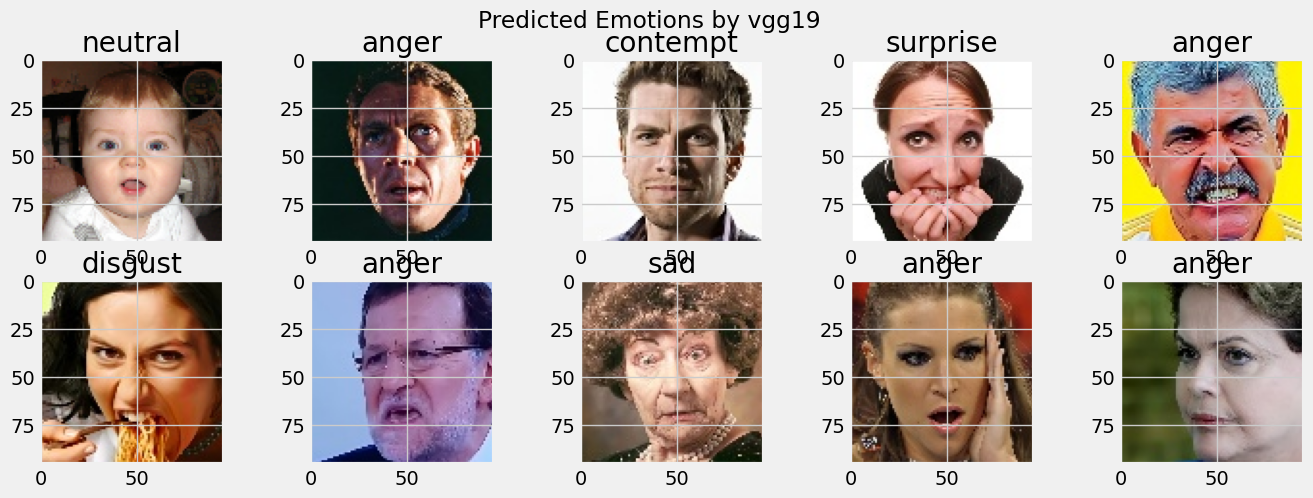

NameError: name 'Plot_ROC' is not defined

In [ ]:
vgg_testx,vgg_pred,vgg_testy = predict(vgg,etol)


In [ ]:
plot_ROC(vgg_pred,vgg_testy)
print ('\n*\t\tClassification Report VGG:\n', classification_report(vgg_testy,vgg_pred) )




*		Classification Report VGG:
               precision    recall  f1-score   support

       anger       0.27      0.27      0.27       232
    contempt       0.34      0.40      0.37       216
     disgust       0.24      0.28      0.25       188
        fear       0.37      0.34      0.35       216
       happy       0.49      0.41      0.45       176
     neutral       0.37      0.42      0.39       172
         sad       0.27      0.18      0.22       203
    surprise       0.19      0.19      0.19       197

    accuracy                           0.31      1600
   macro avg       0.32      0.31      0.31      1600
weighted avg       0.31      0.31      0.31      1600



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

def plot_confusion_matrix(cm, names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_CM(pred_y, original_y, title="Confusion Matrix", categories=None):
    if categories is None:
        categories = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}
    print("*" * 30, title.upper(), "*" * 30)
    
    cm = confusion_matrix(original_y, pred_y)
    np.set_printoptions(precision=2)

    plt.figure(figsize=(20, 10))
    p = random.randint(0, 1)
    k = [plt.cm.Greens, plt.cm.Blues]
    sns.heatmap(cm, annot=True, cmap=k[p], fmt='g')
    
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(tick_marks, list(categories.values()), rotation=90)
    plt.yticks(tick_marks, list(categories.values()))
    plt.show()

# Example usage
# Assuming efficient_pred and efficient_testy are defined
etol = {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}
plot_CM(efficient_pred, efficient_testy, title="Efficient", categories=etol)


NameError: name 'efficient_pred' is not defined